In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import scale
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.cluster import DBSCAN, KMeans
from sklearn.neighbors import KNeighborsClassifier, NearestNeighbors

import folium
import branca
from folium import plugins
import re


In [2]:
df = pd.read_csv('taxi_data.csv')
df.head()

,LON,LAT,NAME
0,28.17858,-25.73882,11th Street Taxi Rank
1,28.17660,-25.73795,81 Bazaar Street Taxi Rank
2,27.83239,-26.53722,Adams Road Taxi Rank
3,28.12514,-26.26666,Alberton City Mall Taxi Rank
4,28.10144,-26.10567,Alexandra Main Taxi Rank


In [3]:
df.isnull().sum()

LON     1
LAT     1
NAME    1
dtype: int64

In [4]:
df=df.dropna()
df=df.drop_duplicates(subset=['NAME'])
df

,LON,LAT,NAME
0,28.17858,-25.73882,11th Street Taxi Rank
1,28.17660,-25.73795,81 Bazaar Street Taxi Rank
2,27.83239,-26.53722,Adams Road Taxi Rank
3,28.12514,-26.26666,Alberton City Mall Taxi Rank
4,28.10144,-26.10567,Alexandra Main Taxi Rank
...,...,...,...
832,28.04441,-26.19727,Zimbabwe Taxi Rank
833,27.82999,-26.24445,Zola Clinic Taxi Rank
834,27.83991,-26.24235,Zola Taxi Rank
835,27.86166,-26.23624,Zondi Taxi Rank


In [5]:
taxis= folium.Map(location=[-25.9,28], zoom_start=9, tiles="OpenStreetMap")
for row_number, row in df.iterrows():
  folium.Circle(
      location = [row["LAT"], row["LON"]],
      radius = 10,
      popup=row['NAME'],
      fill_color="yellow"
  ).add_to(taxis)

taxis

### KMeans Clustering

En primer lugar, utilizaremos el método de clustering más sencillo que es el algoritmo **KMeans**.

Best number of clusters is 100 with a score of 0.61


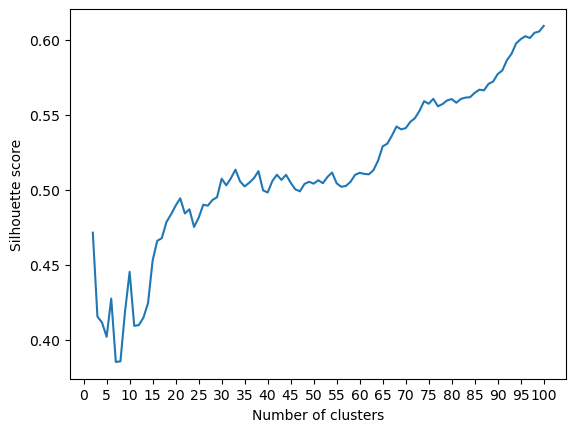

In [6]:
X = df[['LON', 'LAT']]
score = -1
scores = []
k = 0
for i in range(2, 101):
  kmeans = KMeans(n_clusters=i, random_state=3).fit(X)
  score_ = silhouette_score(X, kmeans.predict(X))
  scores.append(score_)
  if score_ > score:
    score = score_
    k=i
    
print(
'Best number of clusters is {} with a score of {:.2f}'
.format(k,score)
)
plt.plot(range(2, 101), scores)
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette score')
plt.xticks(np.arange(0, 101, 5))
plt.show()

Una puntuación de silueta igual a 0,7 (superior a 0,5 y cercana a 1) es suficientemente buena, pero 99 agrupaciones es un número muy grande y no resulta práctico.

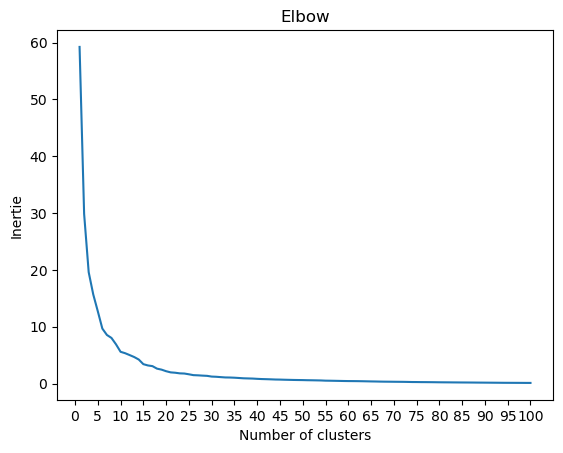

In [7]:
# Elegir el mejor número de clusters utilizando el método del codo
inertia = []
for i in range(1, 101):
  kmeans = KMeans(n_clusters=i, random_state=3).fit(X)
  inertia.append(kmeans.inertia_)
plt.plot(range(1, 101), inertia)
plt.title('Elbow')
plt.xlabel('Number of clusters')
plt.ylabel('Inertie')
plt.xticks(np.arange(0, 101, 5))
plt.show()

Como podemos ver el codo se gira alrededor de 10 agrupaciones, un buen método para conocer un número exacto es usando kneelocator el cual nos dará un punto exacto de rodilla para nuestro modelo.

In [8]:
!pip install kneed

In [9]:
from kneed import KneeLocator
knee_point = KneeLocator(
    range(1, 101),
    inertia,
    curve = 'convex',
    direction = 'decreasing'
)
print(knee_point.knee)

10


In [10]:
kmeans = KMeans(n_clusters=11, random_state=0).fit(X)
inertia_ = kmeans.inertia_
silhouette_ = silhouette_score(X, kmeans.labels_)
print("This model with 11 cluster is characterized by :")
# Iinertia is sum of squared distances of samples to their closest cluster center.
print("Iinertia : {:.3f}".format(inertia_))
print("Silhouette mean score : {:.3f}".format(silhouette_))

This model with 11 cluster is characterized by :
Iinertia : 4.830
Silhouette mean score : 0.473


Por los indicadores no parece un mal resultado.
Así que acepanto este resultado:

In [11]:
df['Cluster_KMeans'] = kmeans.labels_
df.head()

,LON,LAT,NAME,Cluster_KMeans
0,28.17858,-25.73882,11th Street Taxi Rank,9
1,28.17660,-25.73795,81 Bazaar Street Taxi Rank,9
2,27.83239,-26.53722,Adams Road Taxi Rank,4
3,28.12514,-26.26666,Alberton City Mall Taxi Rank,8
4,28.10144,-26.10567,Alexandra Main Taxi Rank,2


Ahora definiremos una lista de colores y una función que cree nuestro mapa con folium

In [12]:
# Show results
colors = ['royalblue', 'maroon', 'forestgreen', 'mediumorchid', 'tan',
          'deeppink', 'olive', 'goldenrod', 'lightcyan', 'navy',
          'springgreen','midnightblue', 'red','brown','limegreen','lime',
          'pink','orchid','crimson','m']*10
vectorizer = np.vectorize(lambda x: colors[x % len(colors)])
df['Colors_KMeans'] = vectorizer(kmeans.labels_)
def create_map(cluster_column, colors_column, title):
    map = folium.Map(location=[X.LAT.mean(),df.LON.mean()],zoom_start=8.5)
    for _,row in df.iterrows():
        folium.CircleMarker(
            location=[row.LAT,row.LON],
            radius=5,
            popup = re.sub(r'\W+', '', row.NAME),
            fill=True,
            color=row[colors_column],
            fill_color=row[colors_column],
        ).add_to(map)

    print(title)
    return map

In [13]:
create_map('Cluster_KMeans','Colors_KMeans','KMeans Clustering')

KMeans Clustering


### DBSCAN
DBSCAN es otro algoritmo de agrupación que considero apropiado para este problema, ya que se trata de datos geográficos que pueden tener una forma y densidad de agrupación variables. Este algoritmo también excluye el ruido y los valores atípicos, a diferencia de KMeans, que utiliza todas las muestras del conjunto de datos. Pero antes de realizar el cálculo DBSCAN, primero tenemos que encontrar el parámetro más importante, epsilon, que es la distancia máxima entre puntos para crear un cluster. Podemos encontrarlo utilizando el algoritmo **NearestNeighbors**.

De la documentación de Scikit-Learn: eps float, default=0.5 La distancia máxima entre dos muestras para que una se considere en la vecindad de la otra. El eps es proporcional al número esperado de vecinos, podemos utilizar los vecinos más cercanos para llegar a una estimación justa para eps. **Seguimos utilizando la biblioteca kneed para obtener el punto de codo**.

In [14]:
nearest_neighbors = NearestNeighbors(n_neighbors=7)
neighbors = nearest_neighbors.fit(X)
distances, indices = neighbors.kneighbors(X)
distances = np.sort(distances[:, 5], axis=0)

<Figure size 500x500 with 0 Axes>

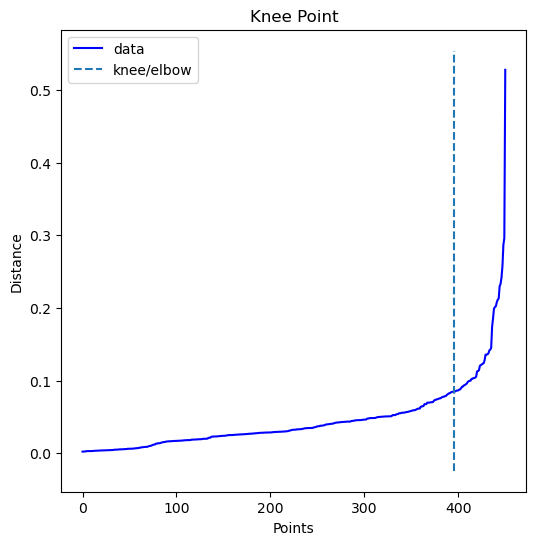

In [15]:
i = np.arange(len(distances))
knee = KneeLocator(
    i, distances, S=1,
    curve='convex',
    direction='increasing',
    interp_method='polynomial'
)
fig = plt.figure(figsize=(5, 5))
knee.plot_knee()
plt.xlabel("Points")
plt.ylabel("Distance")
plt.show()

In [16]:
EPS = round(distances[knee.knee],3)
print('The elbow point is at around {}'.format(EPS))

The elbow point is at around 0.085


In [17]:
dbscan = DBSCAN(eps = EPS)
dbscan.fit(X)
dbscan_predictions = dbscan.labels_
df['Cluster_DBSCAN'] = dbscan_predictions
vectorizer = np.vectorize(
    lambda x: colors[x % len(colors)]
)
df['Colors_DBSCAN'] = vectorizer(dbscan_predictions)

In [18]:
create_map('Cluster_DBSCAN','Colors_DBSCAN','DBSCAN eps={}'.format(EPS))

DBSCAN eps=0.085


In [19]:
round(silhouette_score(X,dbscan_predictions),2)

0.16

Silueta igual a 0,16 no es bueno

In [20]:
n_of_clusters = len(np.unique(dbscan_predictions))
n_of_outliers = len(dbscan_predictions[dbscan_predictions==-1])
print('Number of clusters is: {}'.format(n_of_clusters))
print('Number of outliers is: {}'.format(n_of_outliers))
outliers = [
    (counter+2)*x if x == -1 else x
    for counter,x in enumerate(dbscan_predictions)
]

ign_outliers_score = silhouette_score(
    X[dbscan_predictions != -1],
    dbscan_predictions[dbscan_predictions != -1]
)
outliers_singl_score = silhouette_score(X,outliers)

print(
    'Silhouette score without outliers: {:.2f}'
    .format(ign_outliers_score)
    )
print(
    'Silhouette score with outliers: {:.2f}'
    .format(outliers_singl_score)
    )

Number of clusters is: 6
Number of outliers is: 31
Silhouette score without outliers: 0.22
Silhouette score with outliers: -0.24


La puntuación utilizando eps = 0,05 que se calculó utilizando la estimación NearestNeighbors es muy baja. Utilicemos otro método para determinar eps.

In [21]:
scores_no_outlier = []
scores_with_outlier = []
max_score = 0
best_eps = 0
for i in np.arange(0.15, 0, -0.005):
  dbscan = DBSCAN(eps = i)
  dbscan.fit(X)
  dbscan_predictions = dbscan.labels_
  score_without_outlier = silhouette_score(
      X[dbscan_predictions != -1],
      dbscan_predictions[dbscan_predictions != -1]
  )
  scores_no_outlier.append(score_without_outlier)
  outliers = [
              (counter+2)*x if x==-1 else x
              for counter,x in enumerate(dbscan_predictions)
              ]
  scores_with_outlier.append(silhouette_score(X,outliers))
  if score_without_outlier > max_score:
        max_score = score_without_outlier
        best_eps = i

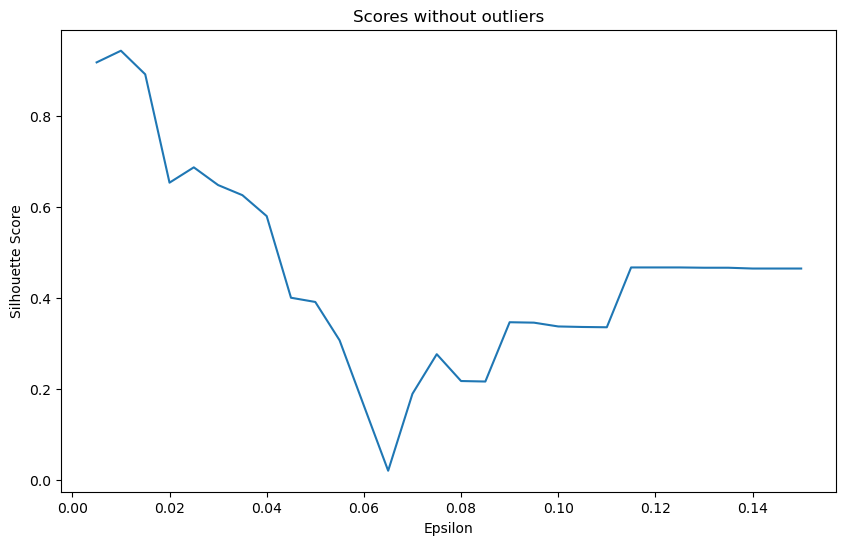

In [22]:
plt.figure(figsize=(10,6))
plt.plot(np.arange(0.15,0,-0.005),scores_no_outlier)
plt.xlabel('Epsilon')
plt.ylabel('Silhouette Score')
plt.title('Scores without outliers')
plt.show()

In [23]:
print(
    'Highest score = {} obtained for epsilon = {}'
    .format(round(max_score,3),round(best_eps,3))
)

Highest score = 0.942 obtained for epsilon = 0.01


In [24]:
dbscan = DBSCAN(eps=0.01)
dbscan.fit(X)
dbscan_predictions = dbscan.labels_
df['Cluster_DBSCAN_OPT'] = dbscan_predictions
vectorizer = np.vectorize(lambda x: colors[x % len(colors)])
df['Colors_DBSCAN_OPT'] = vectorizer(dbscan_predictions)

In [25]:
create_map('Cluster_DBSCAN_OPT','Colors_DBSCAN_OPT','DBSCAN OPT')

DBSCAN OPT


In [26]:
print('Number of clusters: {}'
  .format(len(np.unique(dbscan_predictions))))
print('Number of outliers: {}'
  .format(len(dbscan_predictions[dbscan_predictions==-1])))
outliers=[
          (counter+2)*x if x==-1 else x
          for counter,x in enumerate(dbscan_predictions)]
print('Silhouette score without outliers: {}'
  .format(
      silhouette_score(X[dbscan_predictions!=-1],
      dbscan_predictions[dbscan_predictions!=-1])))
print('Silhouette score with outliers: {}'
  .format(silhouette_score(X,outliers)))

Number of clusters: 11
Number of outliers: 349
Silhouette score without outliers: 0.9424785139987464
Silhouette score with outliers: 0.18402688757796198


### semi-supervised learning

Podemos tratar los valores atípicos utilizando un algoritmo híbrido, DBSCAN + KNearestNeighbors. La idea es combinar un algoritmo de aprendizaje no supervisado y un algoritmo de aprendizaje supervisado. Como ya disponemos de grupos de clusters obtenidos a partir de DBSCAN, clasificaremos los valores atípicos utilizando KNN.

In [27]:
X_train = df[df['Cluster_DBSCAN_OPT'] != -1][['LON', 'LAT']]
y_train = df[df['Cluster_DBSCAN_OPT'] != -1][['Cluster_DBSCAN_OPT']]
X_pred = df[df['Cluster_DBSCAN_OPT'] == -1][['LON', 'LAT']]

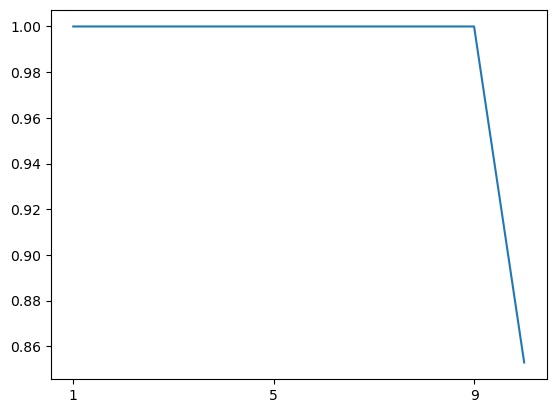

In [28]:
#Averiguamos que valor de vecino es el más óptimo
scores = []
for i in range(1, 11):
  knc = KNeighborsClassifier(n_neighbors=i)
  knc.fit(X_train, y_train.values.ravel())
  scores.append(knc.score(X_train, y_train))
plt.plot(range(1, 11), scores)
plt.xticks(np.arange(1, 11, 4))
plt.show()

Optaremos por tomar 5 vecinos.

In [29]:
KNC = KNeighborsClassifier(n_neighbors=5)
KNC.fit(X_train, y_train.values.ravel())
KNC_predictions = KNC.predict(X_pred)

df['Cluster_Hybrid'] = df['Cluster_DBSCAN_OPT']
df.loc[df['Cluster_DBSCAN_OPT'] == -1, 'Cluster_Hybrid'] = KNC_predictions
vectorizer = np.vectorize(lambda x: colors[x % len(colors)])
df['Colors_Hybrid'] = vectorizer(df['Cluster_Hybrid'].values)

In [30]:
create_map('Cluster_Hybrid','Colors_Hybrid','Hybrid (DBSCAN + KNN)')

Hybrid (DBSCAN + KNN)


In [31]:
print(
    'Number of clusters: {}'
    .format(len(np.unique(df['Cluster_Hybrid']))))
print(
    'Silhouette score: {}'
    .format(round(silhouette_score(X,df['Cluster_Hybrid']),2)))

Number of clusters: 10
Silhouette score: 0.36


### Conclusión
En este problema, utilizamos diferentes técnicas de clustering. Empezamos con el algoritmo KMeans, que es el algoritmo de agrupación más sencillo y rápido. Hemos demostrado que DBSCAN funciona bien con datos de geolocalización, pero la selección del valor épsilon es crítica. También debemos recordar que la puntuación Silhouette cercana a -1 es la peor y 1 es la mejor. Pero Silhouette sólo puede utilizarse como guía para afinar los hiperparámetros y no como métrica absoluta para saber si el cluster es bueno o no.